In [1]:
#Import the required modules for data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#Import the required modules for DataFrame creation:
import pandas as pd

#Import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt
#Import the required modules for optimization:
import scipy as scipy
#We also need additional data:
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss as kpss_t

from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from bcb import currency
from bcb import sgs

import yfinance as yf
import fix_yahoo_finance as yf
import pandas_datareader.data as web

import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


c:\Users\Rodrigo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Rodrigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\Rodrigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Rodrigo\AppData\Roaming\Python\Python38\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [2]:
#ETL dos dados obs.:
df = sgs.get({'indice_ind_transf':28505}, 
             start ='1995-01-31', end='2023-06-30')
df.dropna(inplace=True)
df = df.resample('1M').mean()
curr = currency.get(['USD'], start = '1995-01-31', end = '2023-06-30')
selic = pd.read_excel('../dados/selic_acum_ipea.xlsx')
bndes = pd.read_excel('../dados/desembolso_corrente_bndes_industria.xlsx')
cap = pd.read_excel('../dados/capacidade_instalada_ind.xlsx')
embi = pd.read_excel('../dados/embi_risco.xlsx')
imp = pd.read_excel('../dados/importacao_ind_transf.xlsx')
exp = pd.read_excel('../dados/exportacao_ind_transf.xlsx')
vix = pd.read_excel('../dados/indice_vix.xlsx')
selic.set_index('data', inplace=True)
bndes.set_index('data', inplace=True)
cap.set_index('data', inplace=True)
embi.set_index('data', inplace=True)
imp.set_index('data', inplace=True)
exp.set_index('data', inplace=True)
vix.set_index('Date', inplace=True)
selic = selic.resample('1M').mean()
bndes = bndes.resample('1M').mean()
cap = cap.resample('1M').mean()
curr = curr.resample('1M').mean()
embi = embi.resample('1M').mean()
df['cambio'] = curr['USD']
df['bndes_industria'] = bndes['bndes_industria']
df['selic_acum'] = selic['selic_acum']
df['capacidade_uti'] = cap['capacity_utilization_manufacturing_industry_seasonally_adjusted_%_fgv']
df['embi_risco'] = embi['embi_risco']
df['exportacao'] = exp['exportacao_ind_transf_fob']
df['importacao'] = imp['importacao_ind_transf_fob']
df['vix'] = vix['vix']
df.dropna(inplace=True)
df = df[['vix','embi_risco','cambio','selic_acum','bndes_industria','capacidade_uti','indice_ind_transf','exportacao','importacao']]
df.head(2)

,vix,embi_risco,cambio,selic_acum,bndes_industria,capacidade_uti,indice_ind_transf,exportacao,importacao
Date,,,,,,,,,
2002-01-31,22.252857,845.363636,2.377932,1.53,705.136899,79.8,91.8,3399644841,3375304280
2002-02-28,22.875790,842.800000,2.419600,1.25,1078.935219,79.4,94.2,3099422648,2934193415


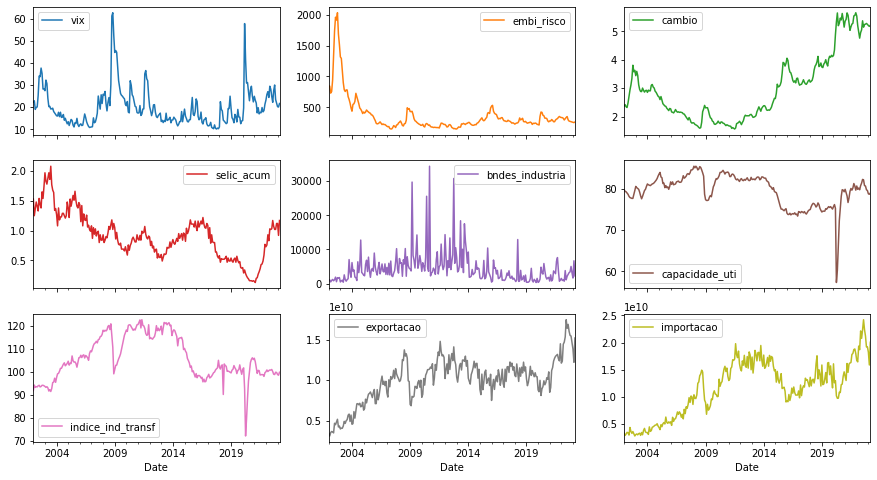

In [3]:
df.plot(subplots=True, layout=(3, 3), figsize=(15,8));

Primeiramente serão analisadas as séries para detectar se possui nível ou nével + tendência.  

In [5]:
### Funcões

def teste_estacionariedade_adf (serie, titulo, rg):
    adf = adfuller(serie, autolag='AIC', regression=rg)
    test_adf = adf[0]
    p_value = adf[1]
    c_value = adf[4]
    c_value = c_value['5%']
    if (test_adf < c_value):
        print('A Série de '+ titulo +' É estacionária para o teste adf com ' + rg)
    else:
        print('A Série de '+ titulo +' NÃO É estacionária para o teste adf com ' + rg)
    print('Teste adf: ' + str(test_adf) + ' | %5: '+ str(c_value) + 
          ' | p_value: '+ str(p_value) 
          )
    print('---------------------------------------------')

def teste_estacionariedade_kpss (serie, titulo, rg):
    kpss = kpss_t(serie, regression=rg)
    test_kpss = kpss[0]
    p_value = kpss[1]
    c_value = kpss[3]
    c_value = c_value['5%']
    if (test_kpss < c_value):
        print('A Série de '+ titulo +' É estacionária para o teste kpss com ' + rg)
    else:
        print('A Série de '+ titulo +' NÃO É estacionária para o teste kpss com ' + rg)
    print('Teste kpss: ' + str(test_kpss) + ' | %5: '+ str(c_value) + 
          ' | p_value: '+ str(p_value) 
          )
    print('---------------------------------------------')

def log_df (df, col='column'):
    df[col+'_log'] = np.log(df[col])
    df.dropna(inplace=True)
    return df

def diff_df (df, col='column'):
    df[col+'_diff'] = df[col].diff()
    df.dropna(inplace=True)
    return df

def diff_2_df (df, col='column'):
    df[col+'_2_diff'] = df[col].diff().diff()
    df.dropna(inplace=True)
    return df

def diff_3_df (df, col='column'):
    df[col+'_3_diff'] = df[col].diff().diff().diff()
    df.dropna(inplace=True)
    return df

In [7]:
#apenas nível 
for column in ['vix','embi_risco','bndes_industria','capacidade_uti','indice_ind_transf']:
    print(column)
    teste_estacionariedade_adf(df[column], column,'c')
    teste_estacionariedade_kpss(df[column], column,'c')
    print('---------------------------------------------')

vix
A Série de vix É estacionária para o teste adf com c
Teste adf: -4.02386205531127 | %5: -2.8730786194395455 | p_value: 0.0012905896366687986
---------------------------------------------
A Série de vix É estacionária para o teste kpss com c
Teste kpss: 0.14057774237872384 | %5: 0.463 | p_value: 0.1
---------------------------------------------
---------------------------------------------
embi_risco
A Série de embi_risco É estacionária para o teste adf com c
Teste adf: -3.2151613266701755 | %5: -2.873032730098417 | p_value: 0.019123685185939376
---------------------------------------------
A Série de embi_risco NÃO É estacionária para o teste kpss com c
Teste kpss: 0.706208187638937 | %5: 0.463 | p_value: 0.012981073851005725
---------------------------------------------
---------------------------------------------
bndes_industria
A Série de bndes_industria NÃO É estacionária para o teste adf com c
Teste adf: -1.8806208608742845 | %5: -2.8735585105960224 | p_value: 0.3412318613481

<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss_t(serie, regression=rg)


In [9]:
for column in ['cambio','selic_acum','importacao','exportacao']:
    print(column)
    teste_estacionariedade_adf(df[column], column,'ct')
    teste_estacionariedade_kpss(df[column], column,'ct')
    print('---------------------------------------------')

cambio
A Série de cambio NÃO É estacionária para o teste adf com ct
Teste adf: -2.08931788388518 | %5: -3.4289434905960645 | p_value: 0.5520731351175303
---------------------------------------------
A Série de cambio NÃO É estacionária para o teste kpss com ct
Teste kpss: 0.529262419348118 | %5: 0.146 | p_value: 0.01
---------------------------------------------
---------------------------------------------
selic_acum
A Série de selic_acum NÃO É estacionária para o teste adf com ct
Teste adf: -2.545853329098582 | %5: -3.4287896430549103 | p_value: 0.3054289291440232
---------------------------------------------
A Série de selic_acum NÃO É estacionária para o teste kpss com ct
Teste kpss: 0.16064566087389318 | %5: 0.146 | p_value: 0.03779528260508901
---------------------------------------------
---------------------------------------------
importacao
A Série de importacao NÃO É estacionária para o teste adf com ct
Teste adf: -1.9075620960311324 | %5: -3.4290999471622556 | p_value: 0.65

<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss_t(serie, regression=rg)


Após aplicação dos testes de estacionariedade ADF e KPSS, nota-se que apenas a variável de risco externo vix é estacionária. Assim, tem-se que diferenciar as séries não estacionária e verificar novamente com os testes.  

In [10]:
dff = df.copy()
cols=['embi_risco','cambio','selic_acum','bndes_industria','capacidade_uti','indice_ind_transf',
      'exportacao','importacao']
for column in cols:
    diff_df(dff, col=column)

- Aplicando o teste de estacionariedade nas séries diferenciadas:

In [13]:
#apenas nível 
for column in ['embi_risco_diff','cambio_diff','selic_acum_diff','bndes_industria_diff',
        'capacidade_uti_diff','indice_ind_transf_diff','exportacao_diff','importacao_diff']:
    print(column)
    teste_estacionariedade_adf(dff[column], column,'c')
    teste_estacionariedade_kpss(dff[column], column,'c')
    print('---------------------------------------------')

embi_risco_diff
A Série de embi_risco_diff É estacionária para o teste adf com c
Teste adf: -6.785716385178712 | %5: -2.8735585105960224 | p_value: 2.435179611265419e-09
---------------------------------------------
A Série de embi_risco_diff NÃO É estacionária para o teste kpss com c
Teste kpss: 0.626916511542785 | %5: 0.463 | p_value: 0.020189408041564993
---------------------------------------------
---------------------------------------------
cambio_diff
A Série de cambio_diff É estacionária para o teste adf com c
Teste adf: -4.0396244006613635 | %5: -2.8740258764297293 | p_value: 0.0012166632119383516
---------------------------------------------
A Série de cambio_diff NÃO É estacionária para o teste kpss com c
Teste kpss: 0.49444008220911334 | %5: 0.463 | p_value: 0.042918900403352854
---------------------------------------------
---------------------------------------------
selic_acum_diff
A Série de selic_acum_diff É estacionária para o teste adf com c
Teste adf: -4.8889866453

<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: Inter

Após a primeira diferença, nota-se que as variáveis embi de risco, câmbio e desembolso de crédito do bndes são não estacionárias para o teste kpss. Logo, serão tomadas a segunda diferença. 

In [14]:
cols=['embi_risco','cambio','bndes_industria']
for column in cols:
    diff_2_df(dff, col=column)

Aplicando novamente os testes para a segunda diferença I(2)

In [15]:
#apenas nível 
for column in ['embi_risco_2_diff','cambio_2_diff','bndes_industria_2_diff']:
    print(column)
    teste_estacionariedade_adf(dff[column], column,'c')
    teste_estacionariedade_kpss(dff[column], column,'c')
    print('---------------------------------------------')

embi_risco_2_diff
A Série de embi_risco_2_diff É estacionária para o teste adf com c
Teste adf: -9.186728429452339 | %5: -2.8744153028455948 | p_value: 2.1775127737839303e-15
---------------------------------------------
A Série de embi_risco_2_diff É estacionária para o teste kpss com c
Teste kpss: 0.05291471779357626 | %5: 0.463 | p_value: 0.1
---------------------------------------------
---------------------------------------------
cambio_2_diff
A Série de cambio_2_diff É estacionária para o teste adf com c
Teste adf: -6.862298631048303 | %5: -2.8743015807562924 | p_value: 1.5910815730200038e-09
---------------------------------------------
A Série de cambio_2_diff É estacionária para o teste kpss com c
Teste kpss: 0.16146243426084644 | %5: 0.463 | p_value: 0.1
---------------------------------------------
---------------------------------------------
bndes_industria_2_diff
A Série de bndes_industria_2_diff É estacionária para o teste adf com c
Teste adf: -8.652660398040902 | %5: -

<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)
<ipython-input-5-99918325fa83>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = kpss_t(serie, regression=rg)


Nota-se que após a segunda diferença I(2), apenas a variável de desembolso de crédito do bndes é não estacionária. Assim, será tomada a terceira diferença I(3). 

In [19]:
diff_3_df(dff, col='bndes_industria')
teste_estacionariedade_adf(dff['bndes_industria_3_diff'], 'bndes_industria_3_diff','c')
teste_estacionariedade_kpss(dff['bndes_industria_3_diff'], 'bndes_industria_3_diff','c')

A Série de bndes_industria_3_diff É estacionária para o teste adf com c
Teste adf: -8.839882993612115 | %5: -2.875206950587861 | p_value: 1.6796448432388477e-14
---------------------------------------------
A Série de bndes_industria_3_diff NÃO É estacionária para o teste kpss com c
Teste kpss: 0.4999999999999552 | %5: 0.463 | p_value: 0.04166666666667676
---------------------------------------------


: 

In [ ]:
teste_estacionariedade_kpss(dff['bndes_industria_3_diff'], 'bndes_industria_3_diff','c')